In [1]:
import numpy as np

import sys
import os

os.environ['TOOLBOX_PATH'] = "/PATH/TO/BART/"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")
sys.path.append("PATH/TO/TOOLS/")

import struct
import cfl

from copy import deepcopy

from matplotlib import pyplot as plt
from matplotlib import lines as lines
from matplotlib import colors as col
from matplotlib import patches as patches
%matplotlib inline

import toolbox as tools

import pickle5 as pickle
import skimage
import nibabel as nib

In [2]:
# Clear all cfls
! rm bart_cfl/*

In [3]:
# General settings

phantom_num = 1
scan = 'BFFE' # 'GRE'


use_adjoint = True

advanced_profile_correction = True

In [4]:
# Additional default settings
num_coils = 6
TR = 4.6

scan_shape = [352, 3000]

In [5]:
# Filepath stuff

file_path = '/scratch/mcgrath/BFlow/Data/phantom_data_2dflow/'

if scan=='GRE':
    if phantom_num==1:
        file_path = file_path + 'meas_MID00020_FID28571_gre_flow_TR4_6_1_6mm_TGA7_3k_BH/'
    else:
        file_path = file_path + 'meas_MID00039_FID28590_gre_flow_TR4_6_1_6mm_TGA7_3k_BH/'
else:
    if phantom_num==1:
        file_path = file_path + 'meas_MID00021_FID28572_bssfp_flow_TR4_6_1_6mm_TGA7_3k_BH/'
    else:
        file_path = file_path + 'meas_MID00040_FID28591_bssfp_flow_TR4_6_1_6mm_TGA7_3k_BH/'


In [6]:
fp = file_path + 'KX_E00_P00.dat'
f = open(fp,'rb')
kx0 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KY_E00_P00.dat'
f = open(fp,'rb')
ky0 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KZ_E00_P00.dat'
f = open(fp,'rb')
kz0 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KW_E00_P00.dat'
f = open(fp,'rb')
kw0 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KX_E00_P01.dat'
f = open(fp,'rb')
kx1 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KY_E00_P01.dat'
f = open(fp,'rb')
ky1 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KZ_E00_P01.dat'
f = open(fp,'rb')
kz1 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KW_E00_P01.dat'
f = open(fp,'rb')
kw1 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

In [7]:
max_k_0 = np.maximum(np.max(kx0),np.max(ky0))
max_k_1 = np.maximum(np.max(kx1),np.max(ky1))

k = (np.sum(np.sqrt(kx0**2 + ky0**2),1)/np.shape(kx0)[1])
dk = k[-1] - k[-2]

In [8]:

kspace0 = np.zeros([scan_shape[0],scan_shape[1],num_coils],dtype=np.complex64)
k0_0 = np.zeros([scan_shape[1],num_coils],dtype=np.complex64);

kspace1 = np.zeros([scan_shape[0],scan_shape[1],num_coils],dtype=np.complex64)
k0_1 = np.zeros([scan_shape[1],num_coils],dtype=np.complex64);
    
for c in range(num_coils):
    
    fp = file_path + 'KDATA_C' + f'{c:02d}' + '_E00_P00.dat'
    f = open(fp,'rb')
    data = np.reshape(np.fromfile(f, dtype=np.float32),[2,scan_shape[0],scan_shape[1]],'F')
    data = np.squeeze(data[0,:,:] + 1j*data[1,:,:])
    kspace0[:,:,c] = data
    k0_0[:,c] = np.squeeze(tools.binning.get_k0(data,kx0,ky0))
    
    fp = file_path + 'KDATA_C' + f'{c:02d}' + '_E00_P01.dat'
    f = open(fp,'rb')
    data = np.reshape(np.fromfile(f, dtype=np.float32),[2,scan_shape[0],scan_shape[1]],'F')
    data = np.squeeze(data[0,:,:] + 1j*data[1,:,:])
    kspace1[:,:,c] = data
    k0_1[:,c] = np.squeeze(tools.binning.get_k0(data,kx1,ky1))
    
    
if advanced_profile_correction:
    kx0,ky0 = tools.random.advanced_radial_shift(np.abs(kspace0),kx0,ky0,factor=8,filter_sigma=6,fixed_xy_shift=False)
    kx1,ky1 = tools.random.advanced_radial_shift(np.abs(kspace1),kx1,ky1,factor=8,filter_sigma=6,fixed_xy_shift=False)
    
kspace0 = kspace0[np.newaxis,...]
kspace1 = kspace1[np.newaxis,...]

In [9]:
kb0 = np.stack([kx0,ky0,kz0],0)
kb0 = kb0[...,np.newaxis]

kb0 = kb0/dk

kb1 = np.stack([kx1,ky1,kz1],0)
kb1 = kb1[...,np.newaxis]

kb1 = kb1/dk

In [10]:
# Write CFL files
cfl.writecfl('bart_cfl/kcoord0', kb0)
cfl.writecfl('bart_cfl/kspace0',kspace0)

cfl.writecfl('bart_cfl/kcoord1', kb1)
cfl.writecfl('bart_cfl/kspace1',kspace1)

In [11]:
cfl.writecfl('bart_cfl/kcoordsens',np.concatenate([kb0,kb1],axis=2))
cfl.writecfl('bart_cfl/kspacesens',np.concatenate([kspace0,kspace1],axis=2))

In [22]:
! bart rss 1 bart_cfl/kcoordsens bart_cfl/kb_rss
! bart fmac bart_cfl/kspacesens bart_cfl/kb_rss bart_cfl/ksp_weighted

! bart nufft -i -g -t bart_cfl/kcoordsens bart_cfl/kspacesens bart_cfl/full_nufft
! bart nufft -a -g -t bart_cfl/kcoordsens bart_cfl/ksp_weighted bart_cfl/adjoint_nufft

if use_adjoint:
    nufft_data = cfl.readcfl('bart_cfl/adjoint_nufft')
else:
    nufft_data = cfl.readcfl('bart_cfl/full_nufft')
sos = np.sqrt(np.sum(np.abs(nufft_data)**2,3))[...,np.newaxis]
#sos = (np.sum(np.abs(nufft_data)**2,3))[...,np.newaxis]
nufft_data = nufft_data/sos
cfl.writecfl('bart_cfl/full_nufft',nufft_data)

! bart fft 3 bart_cfl/full_nufft bart_cfl/full_cart_ksp
#! bart ecalib -m1 -a bart_cfl/full_cart_ksp bart_cfl/sens
! bart caldir 5 bart_cfl/full_cart_ksp bart_cfl/sens

Est. image size: 354x354x1
Done.
Est. image size: 354x354x1
Done.
Calibration region 5x5x1
Done.


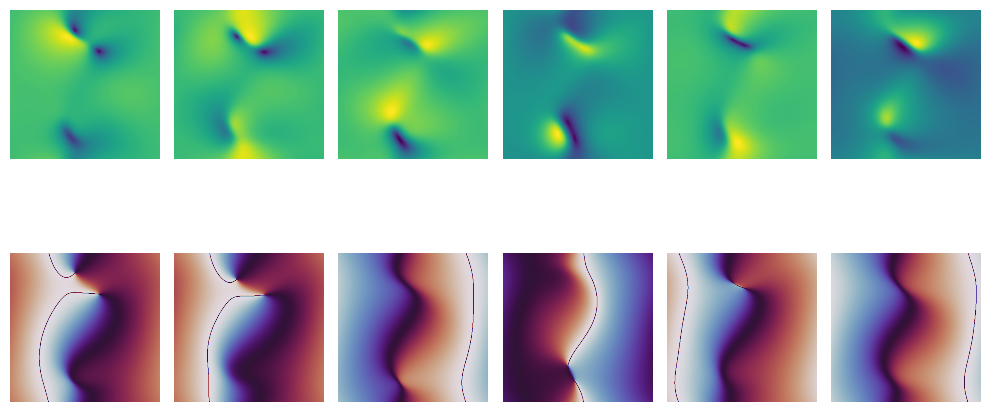

In [23]:
sens = cfl.readcfl('bart_cfl/sens')

row = int(np.ceil(num_coils/6))
plt.close('all')

f, a = plt.subplots(2*row, 6, figsize=(10,3*2*row))

for coil in range(num_coils):
    
    c = np.mod(coil,6)
    r = int(np.floor(coil/6))*2
    
    a[r,c].imshow(np.abs(np.squeeze(sens[:,:,:,coil])))
    a[r+1,c].imshow(np.angle(np.squeeze(sens[:,:,:,coil])),vmin=-np.pi, vmax = np.pi,cmap='twilight')
    
[_.axis("off") for _ in a.flatten()];
f.tight_layout()

In [24]:
! bart pics -g -d3 -i10 S -t bart_cfl/kcoordsens bart_cfl/kspacesens bart_cfl/sens bart_cfl/output 

GPU reconstruction
[  1 352 6000   6   1   1   1   1   1   1   1   1   1   1   1   1 ]
[354 354   1   6   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 352 6000   6   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [354 354   1   6   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 352 6000   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 352 6000   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [708 708   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 352 6000   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 0.127621! (max = 0.127621/p90 = 0.038633/median = 0.015854)
Inverse scaling of the data: 0.127621
Regularization terms: 0, Supporting variables: 0
conjugate gradients
lsqr: add GPU wrapper
Total Time: 3.871262


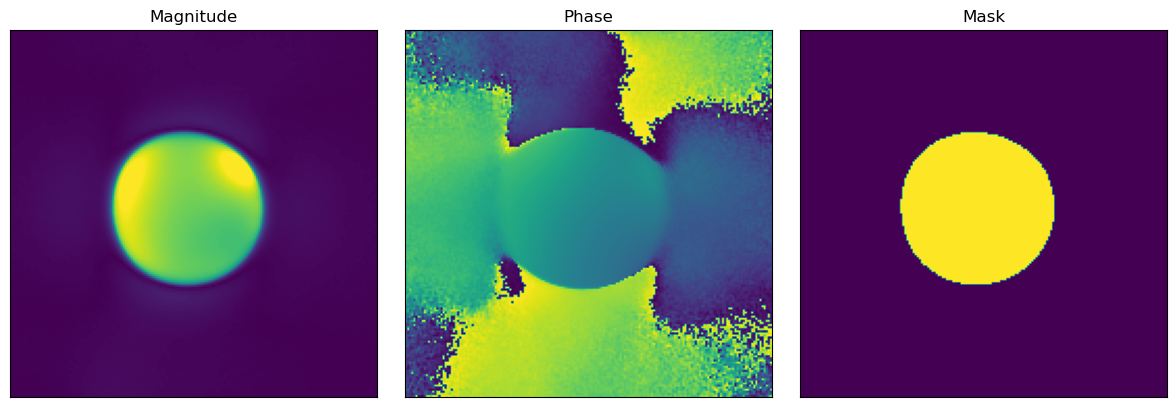

In [25]:
result_uncrop = cfl.readcfl('bart_cfl/output')

! bart crop 0 176 'bart_cfl/output' 'bart_cfl/timeavg'
! bart crop 1 176 'bart_cfl/timeavg' 'bart_cfl/timeavg'

result = cfl.readcfl('bart_cfl/timeavg')

thresh = np.max(np.squeeze(np.abs(result_uncrop))[-50:-1,150:200])

mask = np.squeeze(np.abs(result))>thresh*10
# mask = skimage.morphology.remove_small_objects(mask)
# mask = skimage.morphology.dilation(mask,skimage.morphology.disk(3))
#mask = skimage.morphology.remove_small_holes(mask,10000)

lmax = np.percentile(abs(result),99)

plt.close('all')
f, a = plt.subplots(1, 3, figsize=(12, 4))

a[0].imshow(np.abs(np.squeeze(result[:,:])),vmin=0, vmax = lmax)
a[0].get_xaxis().set_visible(False)
a[0].get_yaxis().set_visible(False)
a[0].set_title("Magnitude")

a[1].imshow(np.angle(np.squeeze(result[:,:])),vmin=-np.pi, vmax = np.pi)
a[1].get_xaxis().set_visible(False)
a[1].get_yaxis().set_visible(False)
a[1].set_title("Phase");

a[2].imshow(mask)
a[2].get_xaxis().set_visible(False)
a[2].get_yaxis().set_visible(False)
a[2].set_title("Mask");


f.tight_layout()

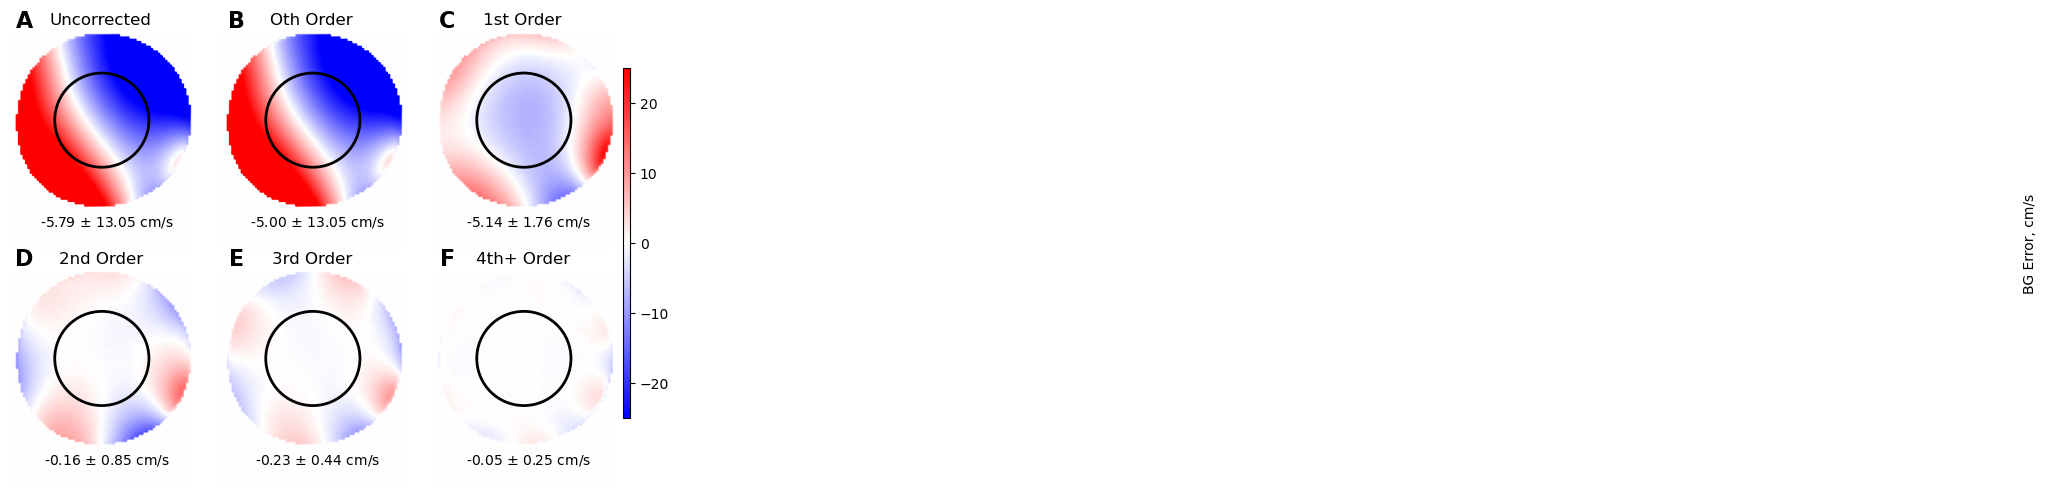

In [26]:
center = [84,85]

ROI = [84,85,20]

plt.close('all')

BGphase0 = tools.random.polyfit2d(np.angle(result),kx=0,ky=0,order=0, mask=mask)
BGphase1 = tools.random.polyfit2d(np.angle(result),kx=1,ky=1,order=1, mask=mask)
BGphase2 = tools.random.polyfit2d(np.angle(result),kx=2,ky=2,order=2, mask=mask)
BGphase3 = tools.random.polyfit2d(np.angle(result),kx=3,ky=3,order=3, mask=mask)
BGphaseHO = tools.random.polyfit2d(np.angle(result),kx=4,ky=3,order=6, mask=mask)

result_cor0 = result * np.exp(-1j*BGphase0)
result_cor1 = result * np.exp(-1j*BGphase1)
result_cor2 = result * np.exp(-1j*BGphase2)
result_cor3 = result * np.exp(-1j*BGphase3)
result_corHO = result * np.exp(-1j*BGphaseHO)

results = [result,result_cor0,result_cor1,result_cor2,result_cor3,result_corHO]
labels = ['Uncorrected','Oth Order','1st Order','2nd Order','3rd Order','4th+ Order']
l = ['A','B','C','D','E','F']

roi_mask = np.zeros_like(np.abs(result_cor0))
roi_mask[ROI[0],ROI[1]] = 1
d = skimage.morphology.disk(ROI[2])
roi_mask = skimage.morphology.binary_dilation(roi_mask,d)

#plt.savefig('Figure_TIFF/phantomGRE_precor.tiff',dpi=500)

f, a = plt.subplots(2, 3, figsize=(7, 5))
fact = 1
pos = [86,45]


a = a.flatten()

for im,idx in zip(results,range(6)):
    
    cim = a[idx].imshow(np.angle(im)/np.pi*149*mask,cmap='bwr',vmin=-25,vmax=25)
    
    circle1 = plt.Circle((ROI[0], ROI[1]), ROI[2] , ec='k', fill=False, lw=2)
    a[idx].add_patch(circle1)
    
    val = roi_mask*np.angle(im)/np.pi*149
    val[roi_mask==0]=np.nan
    m = np.nanmean(val)
    s = np.nanstd(val)
    
    t1 = "{:.2f}".format(m) + r' $\pm$ ' + "{:.2f}".format(s) + ' cm/s'
    a[idx].text(pos[0],pos[1],t1,color='k',fontsize=10,ha = 'center', va='top')
    
    a[idx].set_xlim([45,122])
    a[idx].set_ylim([30,122])
    
    a[idx].text(55,132,l[idx],rotation='horizontal', verticalalignment='top',horizontalalignment='right',fontweight='semibold',fontsize=16,color='k');
    
    a[idx].set_title(labels[idx])
    a[idx].axis('off')
    
#     ticks = np.array([-7.5,-5,-2.5,0,2.5,5,7.5])
#     ticks = ticks/0.16 + 84

#     a[idx].set_yticks(ticks)
#     a[idx].set_yticklabels(['-7.5','-5','-2.5,','0','2.5','5','7.5'])
#     a[idx].set_xticks(ticks)
#     a[idx].set_xticklabels(['-7.5','-5','-2.5,','0','2.5','5','7.5']);
    
cax = f.add_axes([0.91, 0.15, 0.01, 0.70])
f.colorbar(cim, cax=cax, orientation='vertical')
cax.text(200,0,'BG Error, cm/s',color='k',fontsize=10,ha = 'left', va='center', rotation='vertical')

plt.subplots_adjust(left=0.02,right=0.91,top=0.92,bottom=0.01,wspace=0.05,hspace=0.1)

#plt.savefig('Figure_TIFF/Figure 9.tiff',dpi=300,facecolor='white')